# IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import graphviz
import pydotplus
import warnings

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from matplotlib import pyplot
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from IPython.display import Image

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# building model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# ignore warning
warnings.filterwarnings('ignore')

# DATA LOAD

In [ ]:
# get data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read data
df = pd.read_excel('/content/drive/MyDrive/skripsi/DATA-SKRIPSI.xlsx')
df.head()

Kabupaten/Kota  Prevalensi  PPKD      GK     FK   RLS    IPM
0       Simeulue   19.700001  7371  493303  0.040  9.25  67.27
1   Aceh Singkil   10.000000  8994  518951  0.191  8.21  69.62
2   Aceh Selatan   11.700000  8353  446224  0.095  8.43  67.87
3  Aceh Tenggara   12.400000  8222  430825  0.263  9.55  70.32
4     Aceh Timur    6.900000  9127  491550  0.354  8.13  68.72

# PRE-PROCESSING DATA

In [ ]:
# label data
conditions = [
    (df['Prevalensi'] < 2.5),
    (df['Prevalensi'] >= 2.5) & (df['Prevalensi'] < 10),
    (df['Prevalensi'] >= 10) & (df['Prevalensi'] < 20),
    (df['Prevalensi'] >= 20) & (df['Prevalensi'] < 30)
]

bins = [-float('inf'), 2.5, 10, 20, 30, float('inf')]
labels = ['sangat rendah', 'rendah', 'sedang', 'tinggi', 'sangat tinggi']

df['Prevalensi Stunting'] = pd.cut(df['Prevalensi'],
                                   bins=bins,
                                   labels=labels,
                                   right=False)

new_column = ['Kabupaten/Kota','Prevalensi Stunting','PPKD','GK','FK','RLS','IPM','Prevalensi']
df = df[new_column]

df.head()

Kabupaten/Kota Prevalensi Stunting  PPKD      GK     FK   RLS    IPM  \
0       Simeulue              sedang  7371  493303  0.040  9.25  67.27   
1   Aceh Singkil              sedang  8994  518951  0.191  8.21  69.62   
2   Aceh Selatan              sedang  8353  446224  0.095  8.43  67.87   
3  Aceh Tenggara              sedang  8222  430825  0.263  9.55  70.32   
4     Aceh Timur              rendah  9127  491550  0.354  8.13  68.72   

   Prevalensi  
0   19.700001  
1   10.000000  
2   11.700000  
3   12.400000  
4    6.900000

In [ ]:
# drop features
df.drop(['Prevalensi'], axis=1, inplace=True)
df.head()

Kabupaten/Kota Prevalensi Stunting  PPKD      GK     FK   RLS    IPM
0       Simeulue              sedang  7371  493303  0.040  9.25  67.27
1   Aceh Singkil              sedang  8994  518951  0.191  8.21  69.62
2   Aceh Selatan              sedang  8353  446224  0.095  8.43  67.87
3  Aceh Tenggara              sedang  8222  430825  0.263  9.55  70.32
4     Aceh Timur              rendah  9127  491550  0.354  8.13  68.72

In [ ]:
#label data
kategori_mapping = {'sangat rendah': 1, 'rendah': 2, 'sedang': 3, 'tinggi': 4, 'sangat tinggi': 5}
df['Prevalensi'] = df['Prevalensi Stunting'].map(kategori_mapping)

# DESCRIPTIVE STATISTICS

In [ ]:
stat_des = df.drop(['Kabupaten/Kota','Prevalensi Stunting','Prevalensi'],axis=1)
stats = {
    'minimum': stat_des.min().round(2),
    'maksimum': stat_des.max().round(2),
    'rata-rata': stat_des.mean().round(2),
    'standar deviasi': stat_des.std().round(2)
}

stats_df = pd.DataFrame(stats)
stats_df

minimum    maksimum  rata-rata  standar deviasi
PPKD    4559.00    24221.00   10705.63          2707.52
GK    264666.00  1099019.00  488328.97        115084.86
FK         0.00        1.00       0.18             0.18
RLS        1.82       12.86       8.29             1.65
IPM       47.21       87.69      70.83             5.99

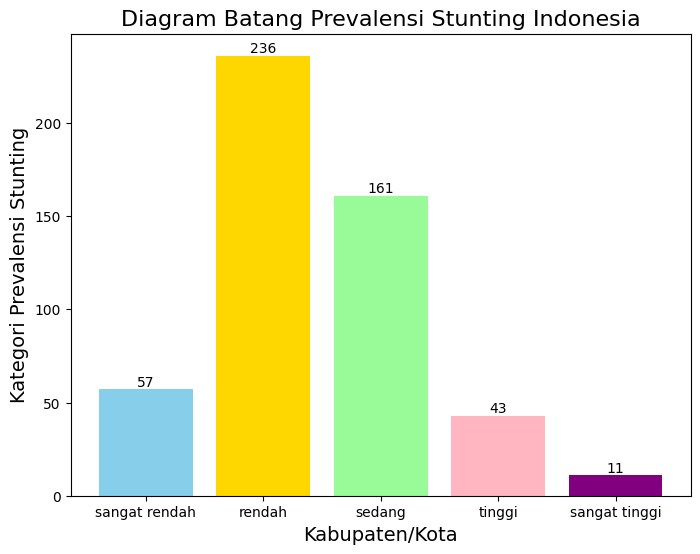

In [ ]:
# bar plot
data = df['Prevalensi Stunting']

counter = Counter(data)
kategori = list(counter.keys())
jumlah = list(counter.values())

kategori_urut = ['sangat rendah', 'rendah', 'sedang', 'tinggi', 'sangat tinggi']
for k in kategori_urut:
    if k not in kategori:
        kategori.append(k)
        jumlah.append(0)

kategori_jumlah = {k: jumlah[kategori.index(k)] for k in kategori_urut}

# bar plot
plt.figure(figsize=(8, 6)) # mengatur ukuran plot

bars = plt.bar(range(len(kategori_urut)), [kategori_jumlah[k] for k in kategori_urut], color=['skyblue','gold','palegreen','lightpink','purple'])

# add value to bar plot
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(kategori_jumlah[kategori_urut[i]]), ha='center', va='bottom')

plt.xticks(range(len(kategori_urut)), kategori_urut)
plt.title('Diagram Batang Prevalensi Stunting Indonesia',fontsize=16)
plt.xlabel('Kabupaten/Kota', fontsize= 14)
plt.ylabel('Kategori Prevalensi Stunting', fontsize= 14)
plt.show()

# DATA SPLITTING

In [ ]:
# define X, y
X= df.drop(columns=['Prevalensi Stunting','Kabupaten/Kota','Prevalensi'],axis=1)
y= df['Prevalensi']

In [ ]:
# split data Extra Trees
X_train_et, X_test_et, y_train_et, y_test_et = train_test_split(X, y, test_size=0.2, random_state=2959)

print('Training dataset\t:', len(X_train_et))
print('Testing dataset\t\t:', len(X_test_et))

Training dataset	: 406
Testing dataset		: 102


In [ ]:
#split data Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=2959)

print('Training dataset\t:', len(X_train_rf))
print('Testing dataset\t\t:', len(X_test_rf))

Training dataset	: 406
Testing dataset		: 102


# EXTRA TREE

## Hyperparameter Tuning

In [ ]:
# GridSearchCV Extra Trees

param_grid = {
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5]
}

et_classifier = ExtraTreesClassifier(random_state=2959)

grid_search_et = GridSearchCV(et_classifier, param_grid, scoring='accuracy', cv=5)
grid_search_et.fit(X_test_et, y_test_et)

print("Hasil Grid Search:")
print("Parameter terbaik:", grid_search_et.best_params_)
print("Akurasi terbaik:", grid_search_et.best_score_)

Hasil Grid Search:
Parameter terbaik: {'max_features': 4, 'min_samples_split': 5, 'n_estimators': 200}
Akurasi terbaik: 0.5314285714285714


In [ ]:
# GridSearchCV result Extra Trees
results_et = grid_search_et.cv_results_
for mean_score, params in zip(results_et["mean_test_score"], results_et["params"]):
    print(f"Akurasi: {mean_score:.4f} dengan parameter {params}")

Akurasi: 0.5014 dengan parameter {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 200}
Akurasi: 0.4814 dengan parameter {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 300}
Akurasi: 0.4814 dengan parameter {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 400}
Akurasi: 0.4819 dengan parameter {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 500}
Akurasi: 0.4719 dengan parameter {'max_features': 2, 'min_samples_split': 2, 'n_estimators': 600}
Akurasi: 0.5014 dengan parameter {'max_features': 2, 'min_samples_split': 3, 'n_estimators': 200}
Akurasi: 0.5114 dengan parameter {'max_features': 2, 'min_samples_split': 3, 'n_estimators': 300}
Akurasi: 0.5210 dengan parameter {'max_features': 2, 'min_samples_split': 3, 'n_estimators': 400}
Akurasi: 0.5114 dengan parameter {'max_features': 2, 'min_samples_split': 3, 'n_estimators': 500}
Akurasi: 0.5210 dengan parameter {'max_features': 2, 'min_samples_split': 3, 'n_estimators': 600}
Akurasi: 0.5014 deng

In [ ]:
# save result to data frame
params_df_et = pd.DataFrame(results_et["params"])
accuracy_df_et = pd.DataFrame({"Akurasi": results_et["mean_test_score"]})
result_et_df = pd.concat([params_df_et, accuracy_df_et], axis=1)
print(result_et_df)

#save result to excel
result_et_df.to_excel("grid_search_results_et.xlsx", index=False)

    max_features  min_samples_split  n_estimators   Akurasi
0              2                  2           200  0.501429
1              2                  2           300  0.481429
2              2                  2           400  0.481429
3              2                  2           500  0.481905
4              2                  2           600  0.471905
..           ...                ...           ...       ...
75             5                  5           200  0.511429
76             5                  5           300  0.501429
77             5                  5           400  0.520952
78             5                  5           500  0.520952
79             5                  5           600  0.510952

[80 rows x 4 columns]


## Modelling

In [ ]:
# build Extra Trees model
n_estimators_et = grid_search_et.best_params_['n_estimators']
max_features_et = grid_search_et.best_params_['max_features']
min_samples_split_et = grid_search_et.best_params_['min_samples_split']

model_et = ExtraTreesClassifier(n_estimators=grid_search_et.best_params_['n_estimators'],
                                max_features=grid_search_et.best_params_['max_features'],
                                min_samples_split=grid_search_et.best_params_['min_samples_split'],
                                random_state=2959)
model_et

ExtraTreesClassifier(max_features=4, min_samples_split=5, n_estimators=200,
                     random_state=2959)

In [ ]:
# fit model
model_et.fit(X_train_et, y_train_et)

ExtraTreesClassifier(max_features=4, min_samples_split=5, n_estimators=200,
                     random_state=2959)

## Predict Data

In [ ]:
# predict labels
y_pred_train_et = model_et.predict(X_train_et)
y_pred_test_et = model_et.predict(X_test_et)

In [ ]:
# predict label vs real label (train)
train_et = pd.DataFrame(y_train_et)
train_et['Predict_Train'] = y_pred_train_et
train_et

Prevalensi  Predict_Train
25           1              1
316          4              4
44           1              1
465          3              3
502          2              2
..         ...            ...
370          1              1
62           2              2
214          3              3
113          1              1
156          1              1

[406 rows x 2 columns]

In [ ]:
# predict label vs real label (test)
test_et = pd.DataFrame(y_test_et)
test_et['Predict_Test'] = y_pred_test_et
test_et

Prevalensi  Predict_Test
73           2             3
166          2             2
417          2             2
58           3             2
97           1             3
..         ...           ...
443          3             2
236          2             3
200          2             2
196          2             2
2            3             3

[102 rows x 2 columns]

In [ ]:
# get prediction for each tree
result_predict_et = []

for tree_idx, tree in enumerate(model_et.estimators_[:200]):
    prediction_et = tree.predict([X_test_et.iloc[101]])  # data ke-n
    result_predict_et.append({'Pohon Ke-': tree_idx + 1, 'Kategori/Kelas': prediction_et[0] + 1})

# save to data frame
df_results_predict_et = pd.DataFrame(result_predict_et)

# save to excel
df_results_predict_et.to_excel('prediksi_et.xlsx', index=False)

# print
print(df_results_predict_et)

     Pohon Ke-  Kategori/Kelas
0            1             2.0
1            2             3.0
2            3             3.0
3            4             3.0
4            5             1.0
..         ...             ...
195        196             3.0
196        197             3.0
197        198             4.0
198        199             2.0
199        200             2.0

[200 rows x 2 columns]


In [ ]:
# majority voting
class_counts = Counter()

for tree_idx, tree in enumerate(model_et.estimators_[:200]):
    prediction_et = tree.predict([X_test_et.iloc[101]])  # data ke-n
    class_counts[prediction_et[0]+1] += 1

most_common_class = class_counts.most_common(1)[0][0]

print(f"Kelas prediksi terbanyak: {most_common_class}")

Kelas prediksi terbanyak: 3.0


## Model Evaluation

In [ ]:
# accuracy
accuracy_et = accuracy_score(y_test_et, y_pred_test_et)

#precision
precision_et = precision_score(y_test_et, y_pred_test_et, average='macro')

#recall
recall_et = recall_score(y_test_et, y_pred_test_et, average='macro')

#f1-score
f1_et = f1_score(y_test_et, y_pred_test_et, average='macro')

# print result
print('Accuracy: ', accuracy_et)
print('Precision: ', precision_et)
print('Recall: ', recall_et)
print('F1 score: ', f1_et)

Accuracy:  0.5490196078431373
Precision:  0.5089473684210526
Recall:  0.48897996357012746
F1 score:  0.4878999788090697


In [ ]:
#classfication report
labels = [1, 2, 3, 4, 5]
print(classification_report(y_test_et, y_pred_test_et, labels=labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.65      0.64      0.64        61
           3       0.39      0.56      0.46        27
           4       0.50      0.25      0.33         4
           5       1.00      1.00      1.00         1

    accuracy                           0.55       102
   macro avg       0.51      0.49      0.49       102
weighted avg       0.52      0.55      0.53       102



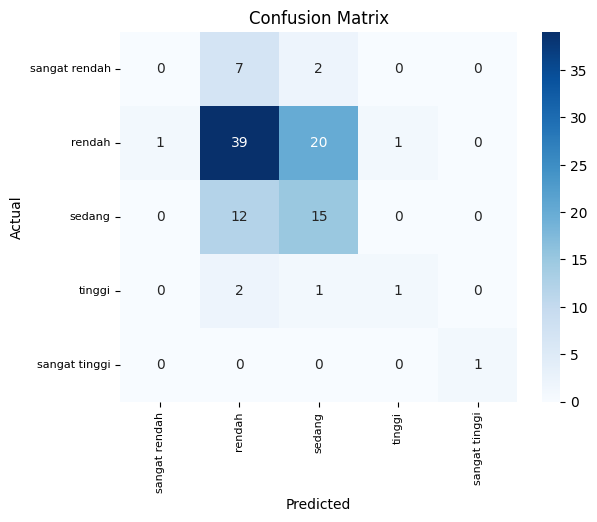

In [ ]:
# confusion matrix
cm_et = confusion_matrix(y_test_et, y_pred_test_et)
cm_et

class_names = ['sangat rendah','rendah','sedang','tinggi','sangat tinggi']

sns.heatmap(cm_et, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(class_names)) + 0.5 ,class_names, size=8, rotation= 90)
plt.yticks(np.arange(len(class_names)) + 0.5 ,class_names, size=8, rotation= -0)
plt.show()

## Features Importance

Feature 1: Nama: PPKD, Score: 0.22963
Feature 2: Nama: GK, Score: 0.19648
Feature 3: Nama: FK, Score: 0.16141
Feature 4: Nama: RLS, Score: 0.21793
Feature 5: Nama: IPM, Score: 0.19454


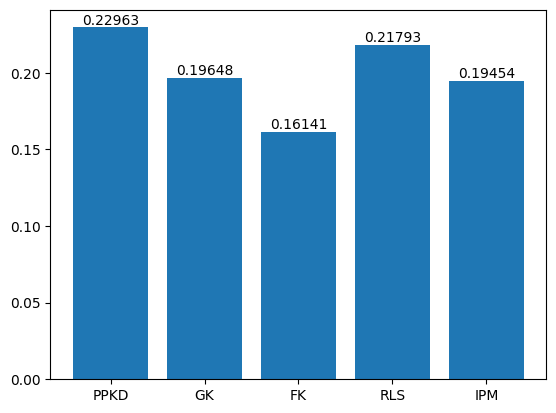

In [ ]:
# get feature importance
feature_names = ['PPKD','GK','FK','RLS','IPM']
importance_et = model_et.feature_importances_

# print feature importance
for i, (feature_name, importance) in enumerate(zip(feature_names, importance_et)):
    print('Feature {}: Nama: {}, Score: {:.5f}'.format(i+1, feature_name, importance))

# bar for feature importance
plt.bar(feature_names, importance_et)

for i, values in enumerate(importance_et):
    plt.text(i, values + 0.002, f'{values:.5f}', ha='center')

plt.xticks()
plt.show()

In [ ]:
# Inisialisasi list untuk menyimpan reduction impurity dari setiap pohon
reduction_impurities = []

# Untuk setiap pohon dalam model
for idx, tree in enumerate(model_et.estimators_):
    # Ambil impurities untuk split di node pertama
    split_impurities = tree.tree_.impurity[tree.tree_.children_left[0]], tree.tree_.impurity[tree.tree_.children_right[0]]
    # Hitung reduction impurity dan tambahkan ke list
    reduction_impurity = np.mean(split_impurities) - tree.tree_.impurity[0]
    reduction_impurities.append(reduction_impurity)

# Hitung rata-rata reduction impurity dari semua pohon
average_reduction_impurity = np.mean(reduction_impurities)
print(f"Average Reduction Impurity: {average_reduction_impurity:.4f}")

Average Reduction Impurity: -0.0251


In [ ]:
# Print Gini Index for each feature in each tree
feature_names = X.columns

for i, tree in enumerate(model_et.estimators_):
    print(f"Tree {i+1}:")
    for j, feature in enumerate(feature_names):
        gini_importance = tree.tree_.compute_feature_importances(normalize=False)[j]
        print(f"{feature}: {gini_importance:.4f}")
    print()

Tree 1:
PPKD: 0.0835
GK: 0.0907
FK: 0.0784
RLS: 0.0819
IPM: 0.0965

Tree 2:
PPKD: 0.1046
GK: 0.0643
FK: 0.0806
RLS: 0.0979
IPM: 0.0997

Tree 3:
PPKD: 0.1187
GK: 0.0881
FK: 0.0853
RLS: 0.0860
IPM: 0.0706

Tree 4:
PPKD: 0.0835
GK: 0.0814
FK: 0.0841
RLS: 0.0962
IPM: 0.1146

Tree 5:
PPKD: 0.0972
GK: 0.0909
FK: 0.0636
RLS: 0.0834
IPM: 0.1012

Tree 6:
PPKD: 0.1046
GK: 0.0941
FK: 0.0686
RLS: 0.0861
IPM: 0.0653

Tree 7:
PPKD: 0.1035
GK: 0.0715
FK: 0.0786
RLS: 0.1120
IPM: 0.0814

Tree 8:
PPKD: 0.1051
GK: 0.0886
FK: 0.0557
RLS: 0.0778
IPM: 0.0883

Tree 9:
PPKD: 0.1050
GK: 0.1059
FK: 0.0828
RLS: 0.0676
IPM: 0.0755

Tree 10:
PPKD: 0.0794
GK: 0.0881
FK: 0.0968
RLS: 0.0628
IPM: 0.1137

Tree 11:
PPKD: 0.1254
GK: 0.0828
FK: 0.0578
RLS: 0.1094
IPM: 0.0704

Tree 12:
PPKD: 0.0989
GK: 0.0593
FK: 0.0663
RLS: 0.1241
IPM: 0.1043

Tree 13:
PPKD: 0.1162
GK: 0.1016
FK: 0.0558
RLS: 0.0674
IPM: 0.1024

Tree 14:
PPKD: 0.0997
GK: 0.0841
FK: 0.0595
RLS: 0.0819
IPM: 0.1025

Tree 15:
PPKD: 0.1158
GK: 0.0897
FK: 0.0519

In [ ]:
trees = []
gini_indices = []

# Specify the feature you want to save Gini Index for
feature_names = X.columns.tolist()
target_feature = 'PPKD'  # Change this to the desired feature

# Calculate Gini Index for the specified feature in each tree and store the results
for i, tree in enumerate(model_et.estimators_):
    feature_index = feature_names.index(target_feature)
    gini_importance = tree.tree_.compute_feature_importances(normalize=False)[feature_index]
    trees.append(i + 1)
    gini_indices.append(gini_importance)

# Create DataFrame from the results
gini_df = pd.DataFrame({
    'Tree': trees,
    'Gini_Index': gini_indices
})

# Print the DataFrame
print(gini_df)

excel_filename = 'gini_index_results.xlsx'
gini_df.to_excel(excel_filename, index_label='Tree')

     Tree  Gini_Index
0       1    0.083536
1       2    0.104557
2       3    0.118692
3       4    0.083489
4       5    0.097201
..    ...         ...
195   196    0.089438
196   197    0.084651
197   198    0.108039
198   199    0.106640
199   200    0.085474

[200 rows x 2 columns]


In [ ]:
# Calculate feature importances manually
importances = np.zeros(X.shape[1])
for tree in model_et.estimators_:
    tree_importances = tree.feature_importances_
    importances += tree_importances

# Normalize importances
importances /= len(model_et.estimators_)

# Print feature importances
print("Feature Importances:")
for i, importance in enumerate(importances):
    print(f"{feature_names[i]}: {importance:.4f}")

Feature Importances:
PPKD: 0.2296
GK: 0.1965
FK: 0.1614
RLS: 0.2179
IPM: 0.1945


In [ ]:
# Calculate feature importances manually
importances = np.zeros(X.shape[1])
for tree in model_et.estimators_:
    tree_importances = tree.feature_importances_
    importances += tree_importances

importances

array([45.92675471, 39.29519414, 32.28275726, 43.58698012, 38.90831377])

In [ ]:
# Initialize array to store impurity values for each feature
impurities = np.zeros(X.shape[1])

# Calculate impurity for each feature in each tree
for tree in model_et.estimators_:
    # Get the feature indices used for splitting in this tree
    feature_indices = tree.tree_.feature
    # Get the impurity values for each node in the tree
    impurity_values = tree.tree_.impurity
    # Calculate impurity for each feature
    for feature_index in feature_indices:
        if feature_index != -2:  # Exclude non-splitting nodes
            impurity = impurity_values[feature_index]
            impurities[feature_index] += impurity

In [ ]:
gini_split= pd.DataFrame(tree.tree_.impurity)
excel_filename = 'gini_split_results.xlsx'
gini_split.to_excel(excel_filename, index_label='Tree')


In [ ]:
# Calculate feature importances manually
importances = np.zeros(X.shape[1])
for tree in model_et.estimators_:
    tree_importances = tree.feature_importances_
    importances += tree_importances

In [ ]:
tree.feature_importances_

array([0.18425338, 0.16525047, 0.21472937, 0.22524394, 0.21052284])

In [ ]:
# Initialize array to store Gini split values
gini_splits = np.zeros(X.shape[1])

# Calculate Gini split for each feature in each tree
for tree in model_et.estimators_:
    # Get the feature indices used for splitting in this tree
    feature_indices = tree.tree_.feature
    # Get the impurity values for each node in the tree
    impurity_values = tree.tree_.impurity
    # Calculate Gini split for each feature
    for feature_index in feature_indices:
        if feature_index != -2:  # Exclude non-splitting nodes
            gini_split = impurity_values[feature_index]
            gini_splits[feature_index] += gini_split

# Normalize by dividing by the number of trees
average_gini_splits = gini_splits / len(model_et.estimators_)

# Print average Gini split for each feature
print("Average Gini Split for each feature:")
for feature_name, gini_split in zip(feature_names, average_gini_splits):
    print(f"{feature_name}: {gini_split:.4f}")

Average Gini Split for each feature:
PPKD: 23.6673
GK: 22.5051
FK: 19.2387
RLS: 21.2570
IPM: 17.1981


## Tree Visualization

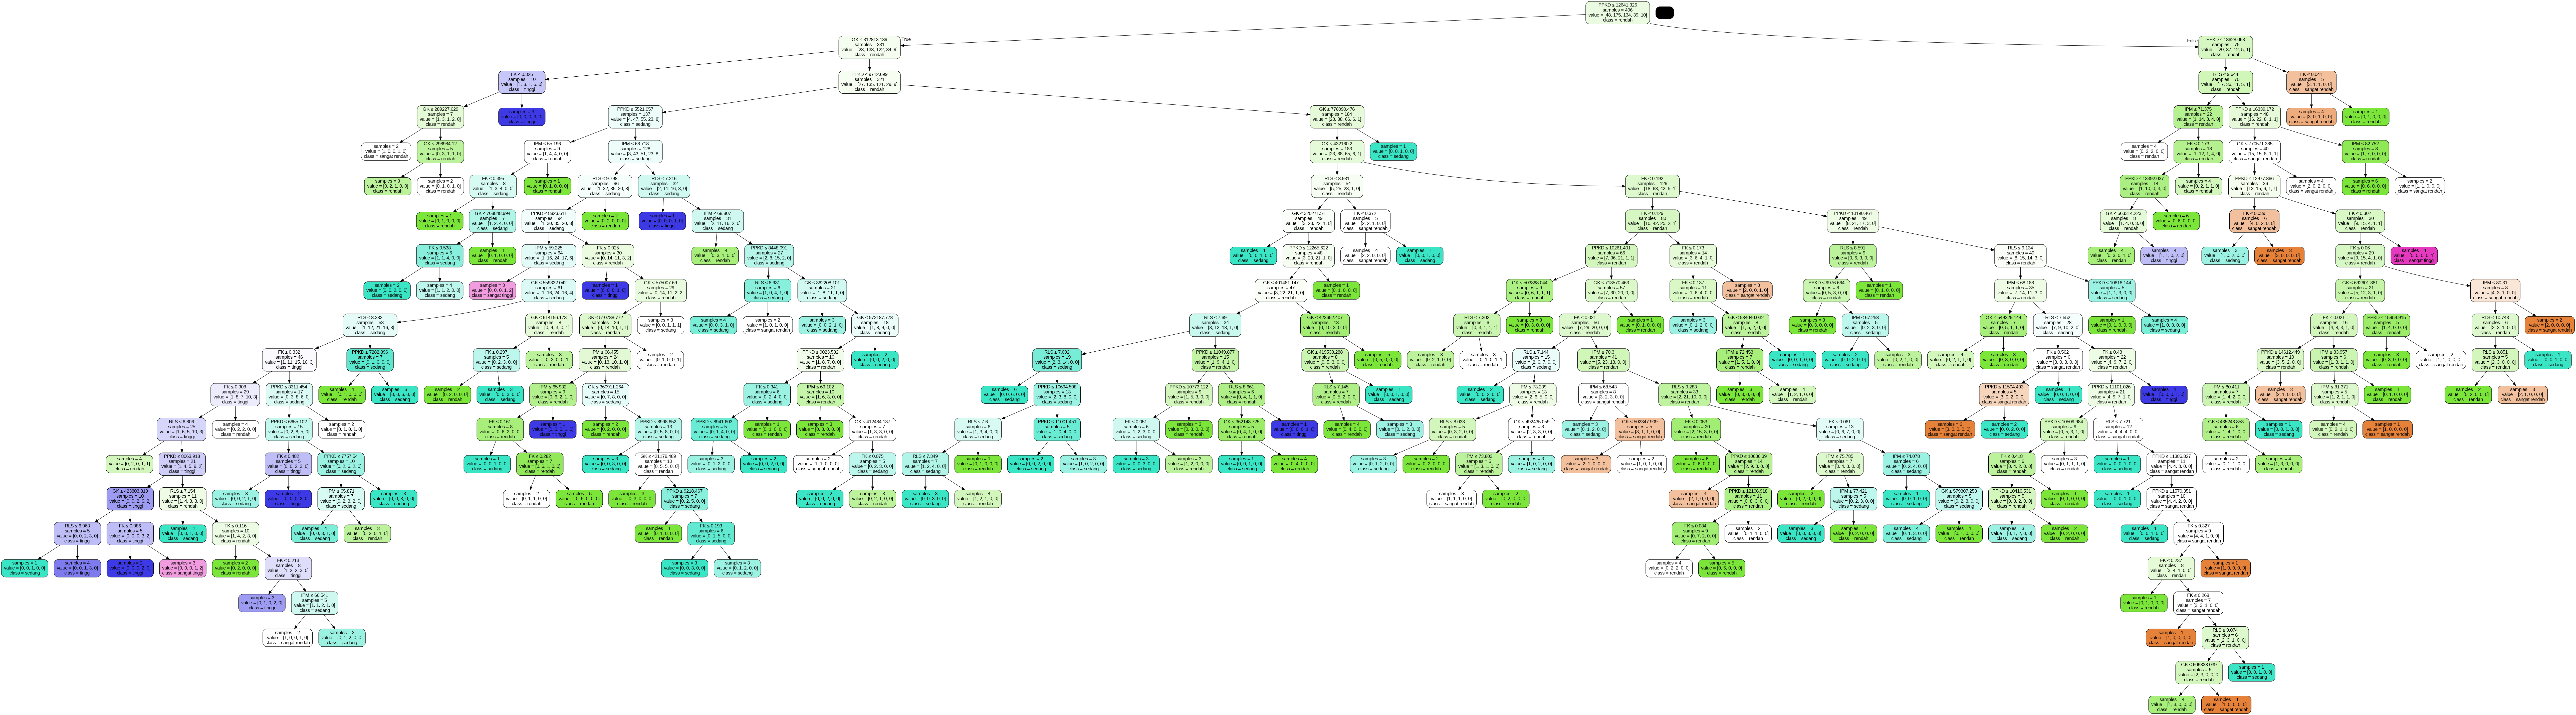

In [ ]:
# tree visualization
pohon_et = model_et.estimators_[49] # pohon ke-
class_names = ['sangat rendah','rendah','sedang','tinggi','sangat tinggi']

dot_data_et = export_graphviz(pohon_et, out_file=None,
                              feature_names=X.columns,
                              class_names=class_names,
                              filled=True, rounded=True,
                              special_characters=True,
                              impurity=False)

graph = pydotplus.graph_from_dot_data(dot_data_et)
graph.write_png("decision_tree_et.png")
Image(graph.create_png())

# RANDOM FOREST

## Hyperparameter Tuning

In [ ]:
# GridSearchCV Random Forest

rf_classifier = RandomForestClassifier(random_state=2959)
param_grid = {
    'bootstrap': [True],
    'n_estimators': [200, 300, 400, 500, 600],
    'max_features': [2, 3, 4, 5]
}

grid_search_rf = GridSearchCV(rf_classifier, param_grid, scoring='accuracy', cv=5)
grid_search_rf.fit(X_test_rf, y_test_rf)

print("Hasil Grid Search:")
print("Parameter terbaik:", grid_search_rf.best_params_)
print("Akurasi terbaik:", grid_search_rf.best_score_)

Hasil Grid Search:
Parameter terbaik: {'bootstrap': True, 'max_features': 2, 'n_estimators': 200}
Akurasi terbaik: 0.5304761904761905


In [ ]:
# GridSearchCV result Random Forest
results_rf = grid_search_rf.cv_results_
for mean_score, params in zip(results_rf["mean_test_score"], results_rf["params"]):
    print(f"Akurasi: {mean_score:.4f} dengan parameter {params}")

Akurasi: 0.5305 dengan parameter {'bootstrap': True, 'max_features': 2, 'n_estimators': 200}
Akurasi: 0.5205 dengan parameter {'bootstrap': True, 'max_features': 2, 'n_estimators': 300}
Akurasi: 0.5105 dengan parameter {'bootstrap': True, 'max_features': 2, 'n_estimators': 400}
Akurasi: 0.5105 dengan parameter {'bootstrap': True, 'max_features': 2, 'n_estimators': 500}
Akurasi: 0.5105 dengan parameter {'bootstrap': True, 'max_features': 2, 'n_estimators': 600}
Akurasi: 0.5105 dengan parameter {'bootstrap': True, 'max_features': 3, 'n_estimators': 200}
Akurasi: 0.5205 dengan parameter {'bootstrap': True, 'max_features': 3, 'n_estimators': 300}
Akurasi: 0.5205 dengan parameter {'bootstrap': True, 'max_features': 3, 'n_estimators': 400}
Akurasi: 0.5205 dengan parameter {'bootstrap': True, 'max_features': 3, 'n_estimators': 500}
Akurasi: 0.5300 dengan parameter {'bootstrap': True, 'max_features': 3, 'n_estimators': 600}
Akurasi: 0.4810 dengan parameter {'bootstrap': True, 'max_features': 4

In [ ]:
# save result to data frane
params_df_rf = pd.DataFrame(results_rf["params"])
accuracy_df_rf = pd.DataFrame({"Akurasi": results_rf["mean_test_score"]})
result_rf_df = pd.concat([params_df_rf, accuracy_df_rf], axis=1)
print(result_rf_df)

# save result to excel
result_rf_df.to_excel("grid_search_results_rf.xlsx", index=False)

    bootstrap  max_features  n_estimators   Akurasi
0        True             2           200  0.530476
1        True             2           300  0.520476
2        True             2           400  0.510476
3        True             2           500  0.510476
4        True             2           600  0.510476
5        True             3           200  0.510476
6        True             3           300  0.520476
7        True             3           400  0.520476
8        True             3           500  0.520476
9        True             3           600  0.530000
10       True             4           200  0.480952
11       True             4           300  0.510476
12       True             4           400  0.510476
13       True             4           500  0.500476
14       True             4           600  0.530000
15       True             5           200  0.491429
16       True             5           300  0.500952
17       True             5           400  0.510952
18       Tru

## Modelling

In [ ]:
#build model Random Forest
model_rfc = RandomForestClassifier(bootstrap=True,
                                   n_estimators=grid_search_rf.best_params_['n_estimators'],
                                   max_features=grid_search_rf.best_params_['max_features'],
                                   random_state=2959)
model_rfc

RandomForestClassifier(max_features=2, n_estimators=200, random_state=2959)

In [ ]:
# fit model
model_rfc.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_features=2, n_estimators=200, random_state=2959)

## Predict Data

In [ ]:
# predict label
y_pred_train_rfc = model_rfc.predict(X_train_rf)
y_pred_test_rfc = model_rfc.predict(X_test_rf)

In [ ]:
# predict label vs real label (train)
train_rf = pd.DataFrame(y_train_rf)
train_rf['Predict_Train'] = y_pred_train_rfc
train_rf

Prevalensi  Predict_Train
25           1              1
316          4              4
44           1              1
465          3              3
502          2              2
..         ...            ...
370          1              1
62           2              2
214          3              3
113          1              1
156          1              1

[406 rows x 2 columns]

In [ ]:
# predict label vs real label (test)
test_rf = pd.DataFrame(y_test_rf)
test_rf['Predict_Test'] = y_pred_test_rfc
test_rf

Prevalensi  Predict_Test
73           2             3
166          2             2
417          2             2
58           3             2
97           1             3
..         ...           ...
443          3             3
236          2             3
200          2             2
196          2             2
2            3             3

[102 rows x 2 columns]

In [ ]:
# get prediction for each tree
result_predict_rf = []

for tree_idx, tree in enumerate(model_rfc.estimators_[:200]):
    prediction_rf = tree.predict([X_test_rf.iloc[101]])  # data ke-n
    result_predict_rf.append({'Pohon Ke-': tree_idx + 1, 'Kategori/Kelas': prediction_rf[0] + 1})

# save to data frame
df_results_predict_rf = pd.DataFrame(result_predict_rf)

# save to excel
df_results_predict_rf.to_excel('prediksi_rf.xlsx', index=False)

# print
print(df_results_predict_rf)

     Pohon Ke-  Kategori/Kelas
0            1             3.0
1            2             5.0
2            3             2.0
3            4             1.0
4            5             2.0
..         ...             ...
195        196             2.0
196        197             4.0
197        198             3.0
198        199             3.0
199        200             2.0

[200 rows x 2 columns]


In [ ]:
# majority voting
class_counts = Counter()

for tree_idx, tree in enumerate(model_rfc.estimators_[:200]):
    prediction_rf = tree.predict([X_test_rf.iloc[101]])  # data ke-n

    class_counts[prediction_rf[0]+1] += 1

most_common_class = class_counts.most_common(1)[0][0]

print(f"Kelas prediksi terbanyak: {most_common_class}")

Kelas prediksi terbanyak: 3.0


## Model Evaluation

In [ ]:
# accuracy
accuracy_rf = accuracy_score(y_test_rf, y_pred_test_rfc)

# precision
precision_rf = precision_score(y_test_rf, y_pred_test_rfc, average='macro')

# recall
recall_rf = recall_score(y_test_rf, y_pred_test_rfc, average='macro')\

# f1-score
f1_rf = f1_score(y_test_rf, y_pred_test_rfc, average='macro')

# print result

print('Accuracy: ', accuracy_rf)
print('Precision: ', precision_rf)
print('Recall: ', recall_rf)
print('F1 score: ', f1_rf)

Accuracy:  0.5392156862745098
Precision:  0.4048317515099223
Recall:  0.43485124468731023
F1 score:  0.41730138713745274


In [ ]:
#classification report
labels = [1, 2, 3, 4, 5]
print(classification_report(y_test_rf, y_pred_test_rfc, labels=labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.66      0.66      0.66        61
           3       0.37      0.52      0.43        27
           4       0.00      0.00      0.00         4
           5       1.00      1.00      1.00         1

    accuracy                           0.54       102
   macro avg       0.40      0.43      0.42       102
weighted avg       0.50      0.54      0.52       102



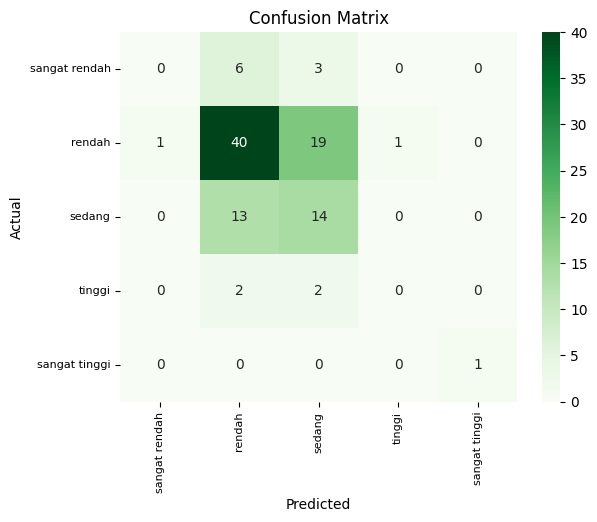

In [ ]:
# confusion matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_test_rfc)
class_names = ['sangat rendah','rendah','sedang','tinggi','sangat tinggi']

sns.heatmap(cm_rf, annot=True, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(np.arange(len(class_names)) + 0.5 ,class_names, size=8, rotation= 90)
plt.yticks(np.arange(len(class_names)) + 0.5 ,class_names, size=8, rotation= -0)
plt.show()

## Features Importance

Feature 1: Nama: PPKD, Score: 0.21851
Feature 2: Nama: GK, Score: 0.19782
Feature 3: Nama: FK, Score: 0.17162
Feature 4: Nama: RLS, Score: 0.21553
Feature 5: Nama: IPM, Score: 0.19652


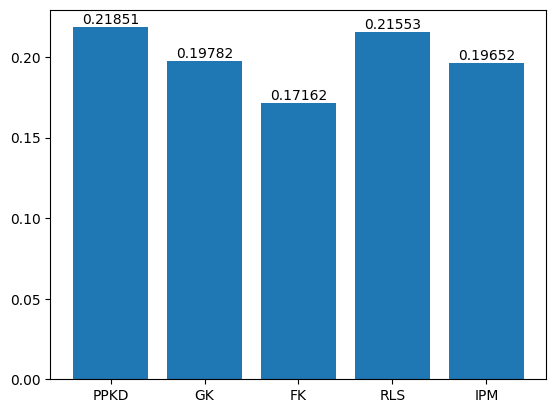

In [ ]:
# get feature importanc
feature_names = ['PPKD','GK','FK','RLS','IPM']
importance_rfc = model_rfc.feature_importances_

# print feature importance
for i, (feature_name, importance) in enumerate(zip(feature_names, importance_rfc)):
    print('Feature {}: Nama: {}, Score: {:.5f}'.format(i+1, feature_name, importance))

# bar for feature importance
plt.bar(feature_names, importance_rfc)

for i, values in enumerate(importance_rfc):
    plt.text(i, values + 0.002, f'{values:.5f}', ha='center')

plt.xticks()
plt.show()

In [ ]:
# Calculate feature importances manually
importances = np.zeros(X.shape[1])
for tree in model_rfc.estimators_:
    tree_importances = tree.feature_importances_
    importances += tree_importances

importances

array([43.70226371, 39.56493867, 34.32446264, 43.10504644, 39.30328854])

## Tree Visualization

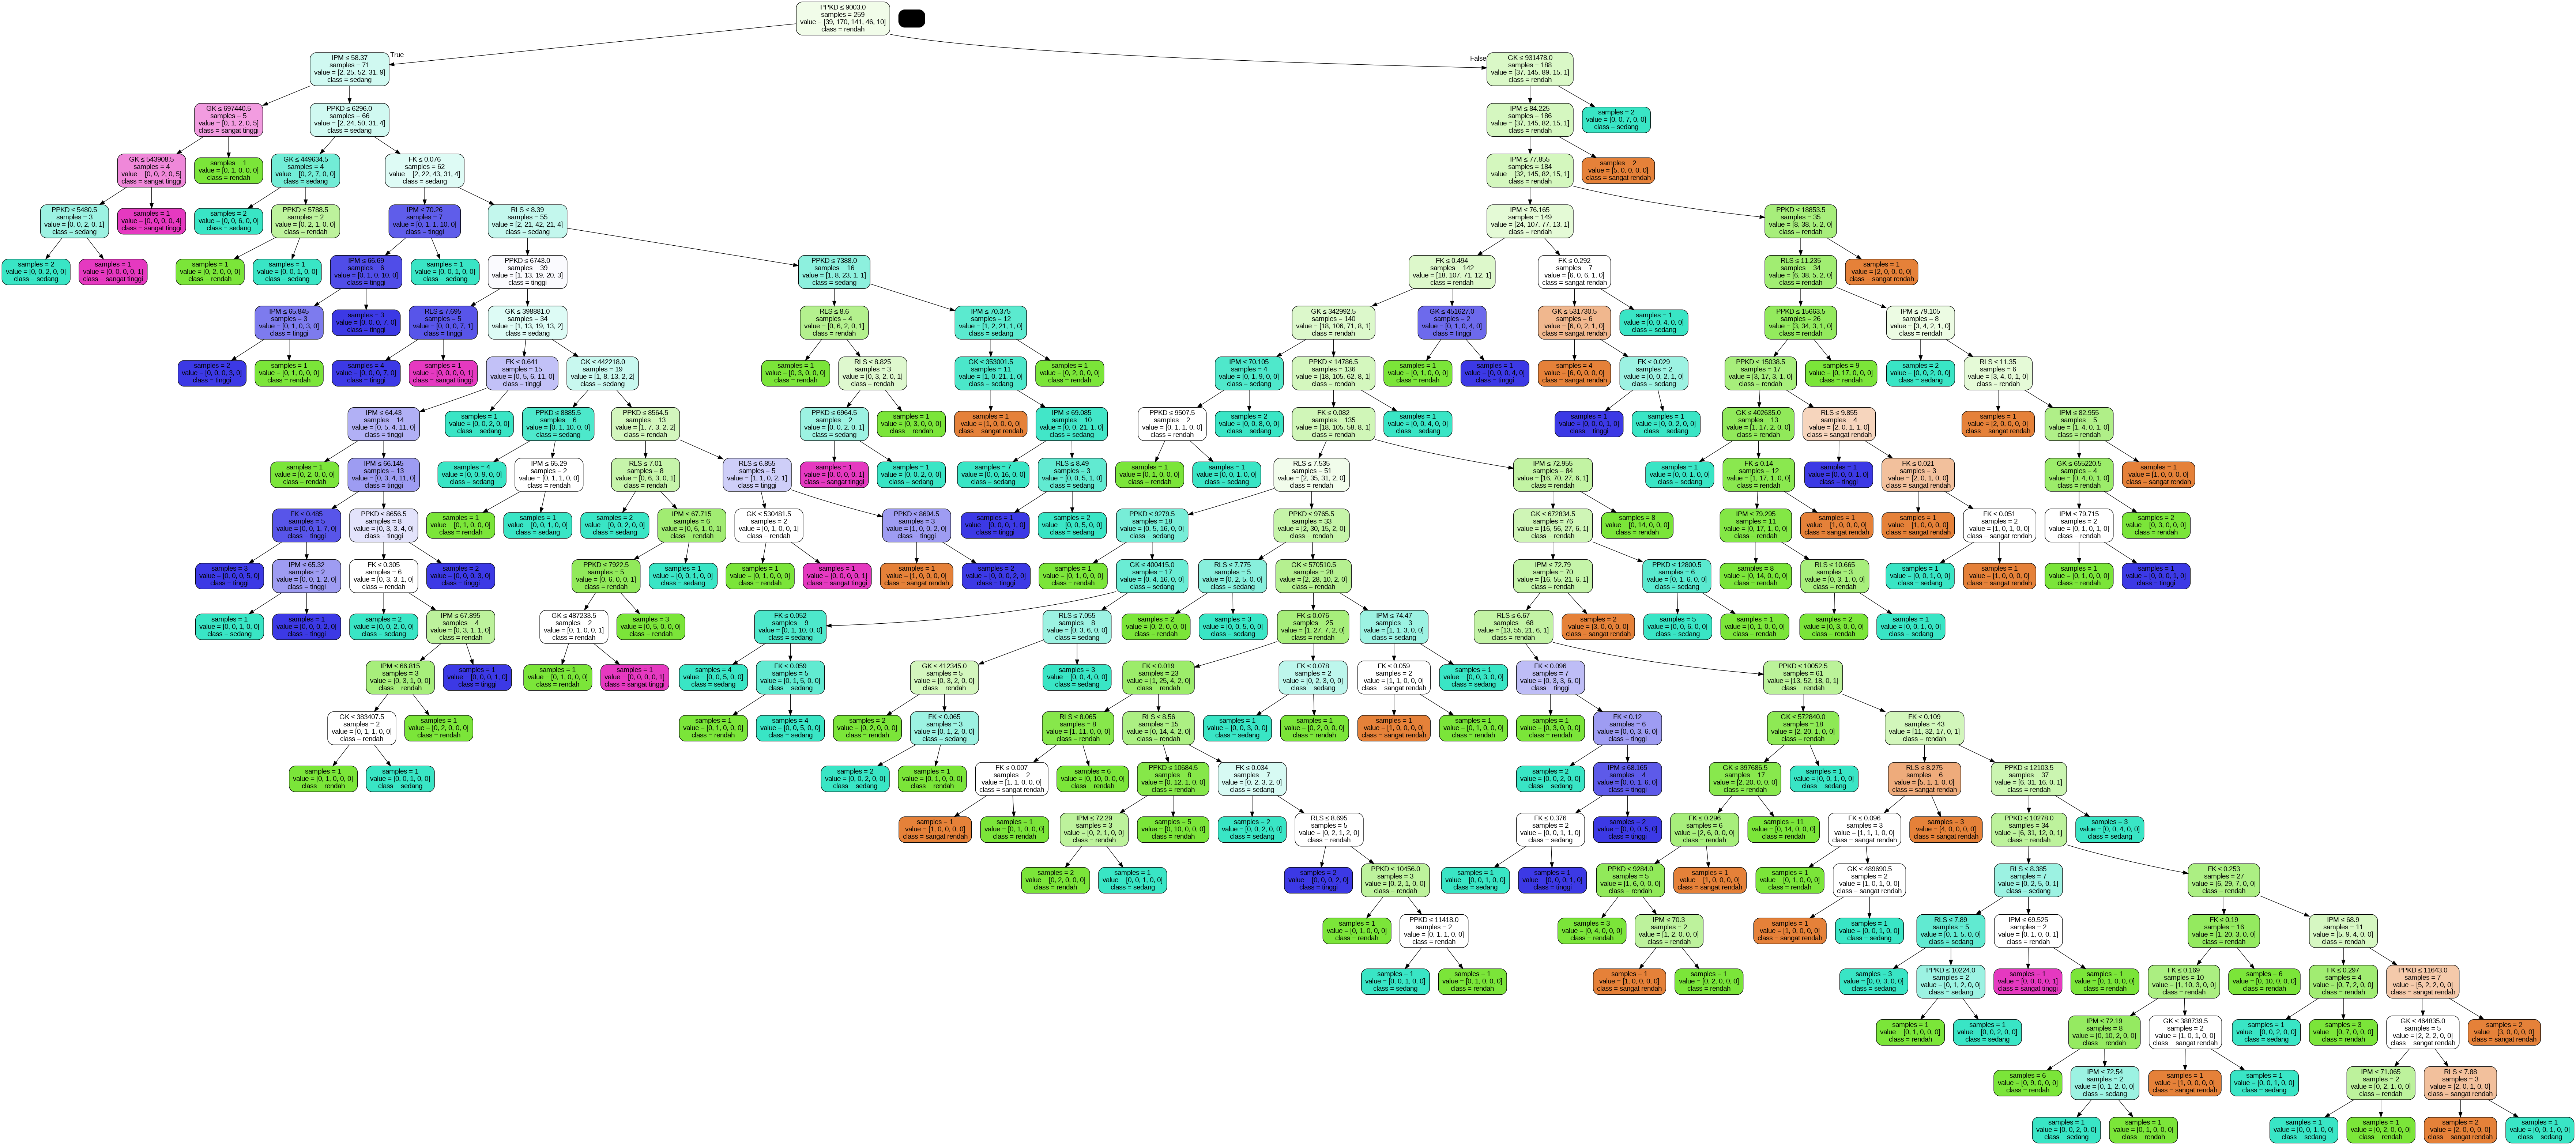

In [ ]:
# tree visualization
pohon_rf = model_rfc.estimators_[49] # pohon ke-
class_names = ['sangat rendah','rendah','sedang','tinggi','sangat tinggi']

dot_data_rf = export_graphviz(pohon_rf, out_file=None,
                              feature_names=X.columns,
                              class_names=class_names,
                              filled=True, rounded=True,
                              special_characters=True,
                              impurity=False)

graph = pydotplus.graph_from_dot_data(dot_data_rf)
graph.write_png("decision_tree.png")
Image(graph.create_png())